# TUTORIAL TIME SERIES
## Insper - PADS
### Financial Analytics
#### Paloma Vaissman Uribe

In [1]:
!python --version

Python 3.9.12


## Tópicos abordados:
Neste tutorial, o aluno irá aprender a rodar em Python alguns dos tópicos abordados na primeira aula do curso Financial Analytics, tais como:

1. Decomposição das séries de tempo em componentes
2. Análise da sazonalidade e previsão de séries usando o Prophet
3. Análise da autocorrelação
4. Teste de raíz unitária (ADF)
5. Modelagem SARIMA

In [5]:
!pip install yahoofinancials

     ---------------------------------------- 41.6/41.6 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for yahoofinancials: filename=yahoofinancials-1.16-py3-none-any.whl size=28712 sha256=18c2683d69c3d920e3c99701209ebc0583d87d6dab4da163a90d26cd54d735cc
  Stored in directory: c:\users\julio\appdata\local\pip\cache\wheels\d0\cd\f5\943633d24e40feda7a852e57aaf3e2d65116a94e7808fa93ab
Successfully built yahoofinancials


In [6]:
# run in first time for installing
#!pip install yfinance
#!pip install YahooFinancials
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Decomposição das séries de tempo

### Componentes:

- Tendência
- Sazonalidade
- Ruído

Podemos pensar em um modelo *aditivo*:

$X_t = T_t + S_t + R_t$, 

ou um modelo *multiplicativo*:

$X_t = T_t*S_t*R_t$, que equivale a

$log(X_t) = log(T_t)+log(S_t)+log(R_t)$

Para exemplificar, vamos fazer o download dos dados da ação da Tesla no formato de uma `pandas dataframe`  usando o pacote `yfinance`:

https://towardsdatascience.com/a-comprehensive-guide-to-downloading-stock-prices-in-python-2cd93ff821d4

In [7]:
tsla_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


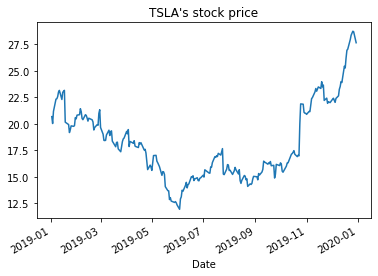

In [4]:
tsla_df['Close'].plot(title="TSLA's stock price");

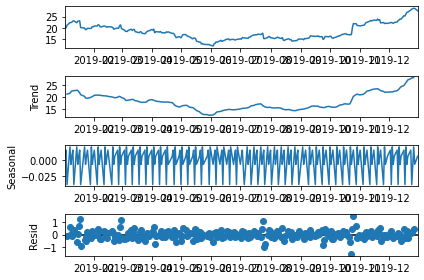

In [8]:
series = tsla_df[['Close']]
result = seasonal_decompose(series, model='additive',period=5)
result.plot()
plt.rcParams["figure.figsize"] = (9,5)
plt.show()

Agora vamos trabalhar com a série tradicional de *airline passengers* para exemplificar a modelagem de sazonalidade.

In [9]:
# Reading airline data
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
airline=pd.read_csv(url,parse_dates = ['Month'],index_col = ['Month'])

In [10]:
airline.dtypes

Passengers    int64
dtype: object

In [11]:
airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


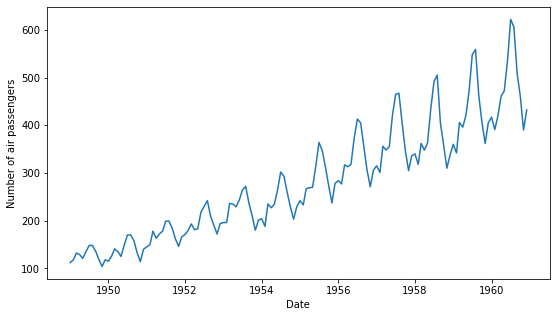

In [9]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(airline);

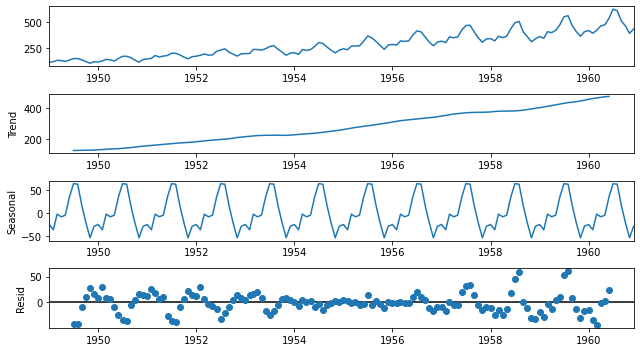

In [12]:
series = airline
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show();

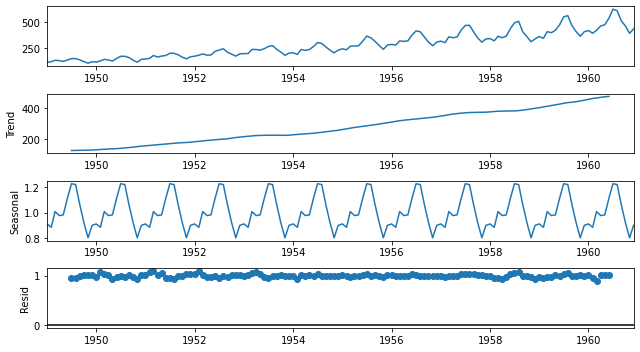

In [13]:
series = airline
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show();

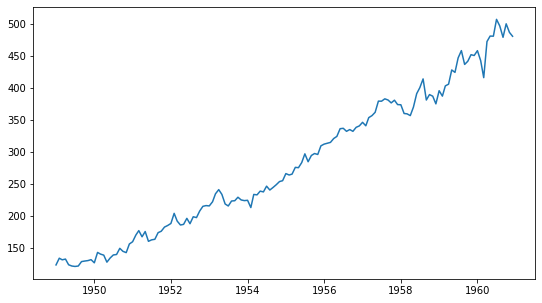

In [14]:
# Deseasonalized data
adj_series = series.squeeze()/result.seasonal
plt.plot(adj_series);

## 2. Análise da sazonalidade e previsão de séries usando o Prophet

Prophet é um pacote do Facebook para realizar **forecasting at scale**. Para maiores detalhes ver https://facebook.github.io/prophet/ ou o paper publicado. Ele permite fazer decomposições das séries e tem módulos interessantes, como múltipla sazonalidade, feriados e também permite o uso de regressores exógenos.

Ele opera com os métodos *fit* e *predict* do `sklearn`. O input é sempre um Pandas dataframe com duas colunas: *y* e *ds*. A coluna *ds* (datestamp) deve ter um formato esperado pelo Pandas, idealmente YYYY-MM-DD para uma data ou YYYY-MM-DD HH:MM:SS para um timestamp. A coluna *y* deve ser numérica e representa a medida que desejamos prever.

In [15]:
# Reading airline data
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
airline=pd.read_csv(url,parse_dates = ['Month'],index_col = ['Month']).reset_index()
airline.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [16]:
df = pd.DataFrame()
df['ds'] = airline['Month']
df['y']= airline['Passengers']
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [17]:
# get index for training dataset
idx = df.shape[0]-12
df.iloc[:idx]

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
127,1959-08-01,559
128,1959-09-01,463
129,1959-10-01,407
130,1959-11-01,362


In [19]:
# fit method
#!pip install prophet
from prophet import Prophet
df_train = df.iloc[:idx]
df_test = df.iloc[idx:]
m = Prophet()
m.fit(df_train)

# make future dataframe
future = m.make_future_dataframe(periods=12, freq='MS')

# predict method
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

21:03:36 - cmdstanpy - INFO - Chain [1] start processing
21:03:36 - cmdstanpy - INFO - Chain [1] done processing
21:03:36 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
21:03:36 - cmdstanpy - INFO - Chain [1] start processing
21:03:36 - cmdstanpy - INFO - Chain [1] done processing
21:03:36 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\julio\miniconda3\Lib\site-packages\prophet\stan_model\prophet_model.bin random seed=52969 data file=C:\Users\julio\AppData\Local\Temp\tmp42hghbmz\2_o8wl21.json init=C:\Users\julio\AppData\Local\Temp\tmp42hghbmz\arnshplx.json output file=C:\Users\julio\AppData\Local\Temp\tmp42hghbmz\prophet_modelx5n9opa4\prophet_model-20230728210336.csv method=optimize algorithm=newton iter=10000' failed: 

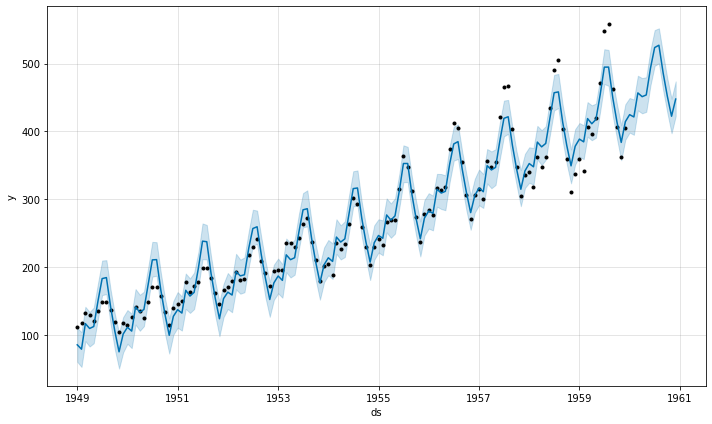

In [25]:
fig1 = m.plot(forecast)

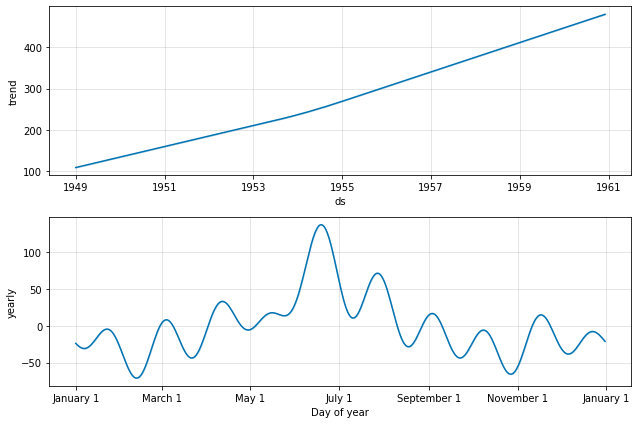

In [17]:
# components
fig2 = m.plot_components(forecast)

In [18]:
# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
y_true = df_test['y']
y_pred = forecast.iloc[idx:]['yhat']
np.sqrt(mean_squared_error(y_true, y_pred))

43.099703285478114

In [19]:
## improving fit with multiplicative seasonality

# fit method
m2 = Prophet(seasonality_mode='multiplicative')
m2.fit(df_train)

# make future dataframe: note to specify frequency here
future = m2.make_future_dataframe(periods=12, freq='MS')

# predict method
forecast2 = m2.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,573.180448,560.161714,586.476265
140,1960-09-01,496.480973,484.580731,508.685637
141,1960-10-01,433.225414,419.923454,445.237954
142,1960-11-01,379.648299,367.166297,393.558752
143,1960-12-01,420.351115,407.373657,433.597572


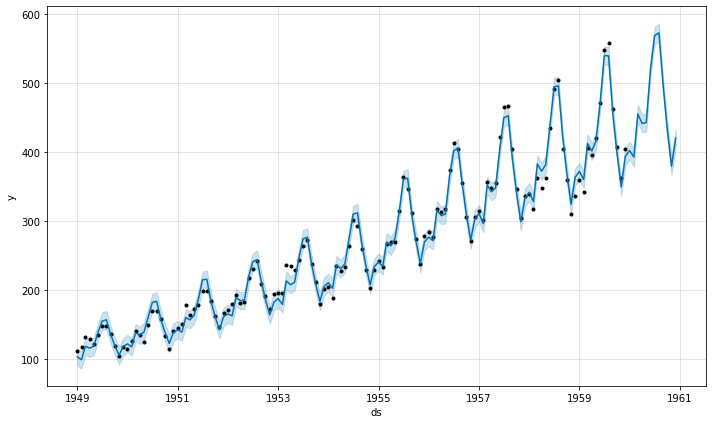

In [20]:
fig3 = m2.plot(forecast2)

In [21]:
# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
y_true = df_test['y']
y_pred = forecast2.iloc[idx:]['yhat']
np.sqrt(mean_squared_error(y_true, y_pred))

25.840324452533

## 3. Análise da função de autocorrelação 

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

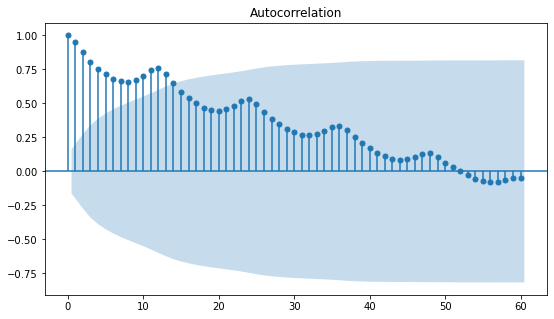

In [23]:
# autocorrelation and partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series, lags=60)
plt.show()

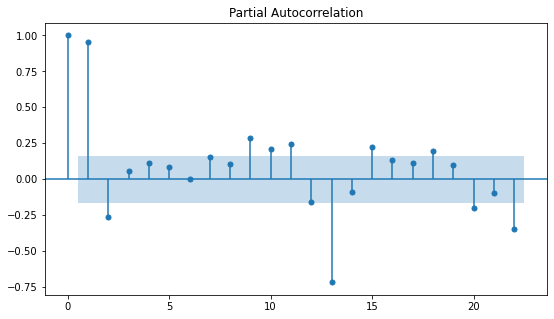

In [24]:
plot_pacf(series)
plt.show()

## 4. Teste de raíz unitária

In [25]:
# ADF test: unit root
adf = adfuller(airline['Passengers'])
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.8153688792060502
p-value: 0.991880243437641
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -695.294
Date:                Fri, 14 Oct 2022   AIC                           1396.588
Time:                        11:16:41   BIC                           1405.476
Sample:                    01-01-1949   HQIC                          1400.200
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3815      0.088      4.351      0.000       0.210       0.553
ar.L2         -0.2279      0.065     -3.518      0.000      -0.355      -0.101
sigma2       977.5538    111.534      8.765      0.0

/Users/paloma.uribe/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/paloma.uribe/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/paloma.uribe/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


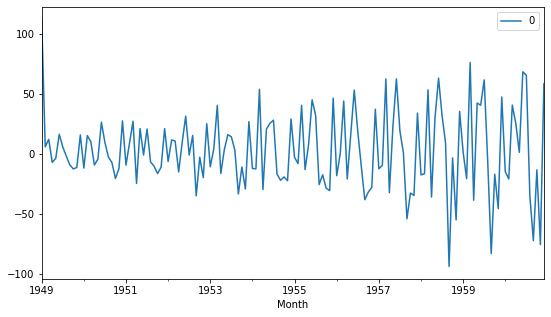

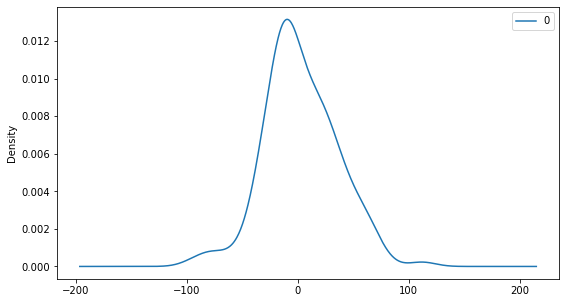

                0
count  144.000000
mean     2.818626
std     32.517191
min    -93.580702
25%    -16.713262
50%     -2.155845
75%     25.208576
max    112.000000


In [26]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(series, order=(2,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [27]:
#using auto.arima
#!pip install pmdarima
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(series)

(0.01, False)

## 5. Modelagem SARIMA

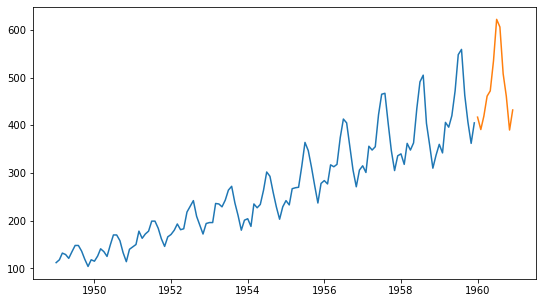

In [28]:
train = series[:idx]
test = series[idx:]
plt.plot(train);
plt.plot(test);

In [29]:
from pmdarima import auto_arima

arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, D=1, 
                         start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal = True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -447.951
Date:                            Fri, 14 Oct 2022   AIC                            899.902
Time:                                    11:16:43   BIC                            905.460
Sample:                                         0   HQIC                           902.159
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2431      0.090     -2.697      0.007      -0.420      -0.066
sigma2       108.8757     13.306      8.183      0.000      82.797     134.954
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.89   Prob(JB):                         0.75
Heteroskedasticity (H):               1.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 12), index = test.index)
prediction.columns = ['pred']

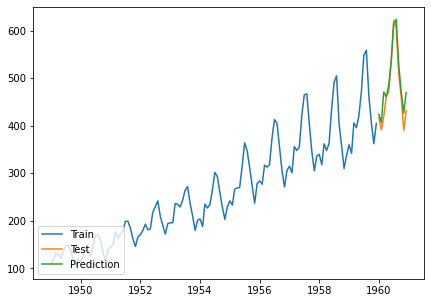

In [31]:
plt.figure(figsize=(7,5))
plt.plot(train, label = "Train")
plt.plot(test, label = "Test")
plt.plot(prediction, label = "Prediction")
plt.legend(loc = 'lower left')
plt.show()

In [32]:
# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
y_true = test
y_pred = prediction
np.sqrt(mean_squared_error(y_true, y_pred))

23.931673184375324